# RE-IMAGE GENERATION

In [1]:
# Training Loss: MSE
attempt = "6"

### EEG Data

In [2]:
import os
import pickle

path = '/kaggle/input/preprocessed-multiband/'
with open(os.path.join(path, "preprocessed_multiband_eeg.pkl"), "rb") as f:
    processed = pickle.load(f)

In [3]:
X_preprocessed = processed['X']
y_preprocessed = processed['y']

print(X_preprocessed['delta'].shape)
print(y_preprocessed.shape)

(34230, 32, 125)
(34230,)


In [4]:
from keras.utils import to_categorical
import numpy as np

X_preprocessed = np.stack([
    X_preprocessed['delta'],
    X_preprocessed['theta'],
    X_preprocessed['alpha'],
    X_preprocessed['beta']
], axis=1)

X_transposed_pre = np.transpose(X_preprocessed, (0, 1, 3, 2))
y_cat_pre = to_categorical(y_preprocessed, num_classes=10)

print(X_transposed_pre.shape)
print(y_cat_pre.shape)

2025-07-16 17:18:37.498627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752686317.706473      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752686317.763557      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(34230, 4, 125, 32)
(34230, 10)


### Image Data

In [5]:
import os
import numpy as np

path = "/kaggle/input/mnist-images/"
images = np.load(os.path.join(path, "MNIST_images.npy"))

#### Data Pairing (MNIST with Combined Signals)

In [6]:
import os
import numpy as np

path = '/kaggle/input/preprocessed-multiband/'
used_indices = np.load(os.path.join(path, 'used_indices.npy'))

In [7]:
global_images = []

for i in range(len(used_indices)):
    group_image = images[used_indices[i]]
    
    # Calculate mean of images from the group
    mean_img = np.mean(group_image, axis=0)

    # Take the most representative one (according to MSE)
    MSE_list = [np.mean((img - mean_img)**2) for img in group_image]
    representative_image = images[used_indices[i][np.argmin(MSE_list)]]
    global_images.append(representative_image)

global_images = np.array(global_images)
print(global_images.shape)

(30000, 28, 28)


#### Add Padding
##### (28x28) => (32x32)

In [8]:
padded = np.pad(np.array(global_images), ((0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0)
print(padded.shape)

(30000, 32, 32)


#### Duplicate Data for Augmented

In [9]:
duplicated = []
for src in processed['duplication_sources']:
    if (isinstance(src, tuple)):
        (src1, src2), lam = src
        if (lam < 0.5):
            duplicated.append(padded[src2])
        else:
            duplicated.append(padded[src1])
    else:
        duplicated.append(padded[src])

print(len(duplicated))

4230


In [10]:
combined = np.concatenate([padded, duplicated], axis=0)
print(combined.shape)

(34230, 32, 32)


### Feature Extraction and Classification Model

In [11]:
from tensorflow.keras.models import Model

def make_pairs(model, X, y, imgs):
    encoder_model = Model(inputs=model.input, outputs=model.get_layer('latent_vector').output)
    encoder_model.compile()
    latent_vectors = encoder_model.predict(X)
    
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y, axis=1)
    true_indices = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i]]

    final_true_pairs = [(latent_vectors[i],
                         y[i],        
                         imgs[i])
                         for i in true_indices]
    
    final_false_pairs = [(latent_vectors[i],
                         y[i],        
                         imgs[i])
                         for i in range(len(y_pred)) 
                         if i not in true_indices]

    return final_true_pairs, final_false_pairs

In [12]:
from sklearn.model_selection import train_test_split

X_train_pre, X_val_pre,    \
y_train_pre, y_val_pre,    \
img_train_pre, img_val_pre \
    = train_test_split (
        X_transposed_pre, 
        y_cat_pre,
        combined,
    
        test_size    = 0.2,
        random_state = 42, 
        shuffle      = True, 
        stratify     = y_cat_pre
    )

In [13]:
# BEST CLASSIFICATION FOR PREPROCESSED DATA
import tensorflow as tf
import os

save_dir = f"/kaggle/input/best-lstm-final-multiband/keras/default/1"
best_model = tf.keras.models.load_model(os.path.join(save_dir, f'best_LSTM_final_multiband.keras'))

I0000 00:00:1752686362.097085      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752686362.097778      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
final_pre_pairs, _ = make_pairs(best_model, X_train_pre, y_train_pre, img_train_pre)

I0000 00:00:1752686370.943980      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


856/856 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step
856/856 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step


## cDCGAN

In [15]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

### Supportive Functions

In [16]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [18]:
import torch

all_z = torch.cat([torch.tensor(z) for z, _, _ in final_pre_pairs], dim=0)
all_y = torch.cat([torch.tensor(y) for _, y, _ in final_pre_pairs], dim=0)

real_imgs = torch.cat([torch.tensor(img).unsqueeze(0) for _, _, img in final_pre_pairs])

# !!!!!!!!!!!!!! NORMALIZATION !!!!!!!!!!!!!!
real_imgs = (real_imgs.float() / 255.0 - 0.5) / 0.5

fixed_z_ = all_z.view(-1, 100, 1, 1).float().cuda()
fixed_y_label_ = all_y.view(-1, 10, 1, 1).float().cuda()
real_imgs = real_imgs.unsqueeze(1).cuda()

In [19]:
print(fixed_z_.shape)
print(fixed_y_label_.shape)
print(real_imgs.shape)

torch.Size([12751, 100, 1, 1])
torch.Size([12751, 10, 1, 1])
torch.Size([12751, 1, 32, 32])


In [20]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [21]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

### Generator and Discriminator

#### Generator

In [22]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x

#### Discriminator

In [23]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(1, d//2, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(10, d//2, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

### TRAINING

In [24]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 20

# data_loader
img_size = 32
padding_size = (2, 2, 2, 2)

#### Network Initialization

In [25]:
# network
G = generator(128)
D = discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

# MSE loss
loss = nn.MSELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
root = 'MNIST_cDCGAN_results/'
model = 'MNIST_cDCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# label preprocess
fill = torch.zeros([10, 10, img_size, img_size])
for i in range(10):
    fill[i, i, :, :] = 1
fill = fill.float().cuda()

#### Training Start

In [26]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(fixed_z_, fixed_y_label_, real_imgs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [27]:
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []

    # learning rate decay
    if (epoch+1) == 11:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    if (epoch+1) == 16:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    epoch_start_time = time.time()
    
    y_real_ = torch.ones(batch_size)
    y_fake_ = torch.zeros(batch_size)
    y_real_, y_fake_ = Variable(y_real_.cuda()), Variable(y_fake_.cuda())
    
    for z_, y_label_, x_ in dataloader:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        if mini_batch != batch_size:
            y_real_ = torch.ones(mini_batch)
            y_fake_ = torch.zeros(mini_batch)
            y_real_, y_fake_ = Variable(y_real_.cuda()), Variable(y_fake_.cuda())

        label_indices = y_label_.squeeze(-1).squeeze(-1).argmax(dim=1)
        y_fill_ = fill[label_indices]

        D_result = D(x_, y_fill_).squeeze()
        D_real_loss = loss(D_result, y_real_)
        
        G_result = G(z_, y_label_)
        D_result = D(G_result, y_fill_).squeeze()

        D_fake_loss = loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        G_result = G(z_, y_label_)
        D_result = D(G_result, y_fill_).squeeze()

        G_train_loss = loss(D_result, y_real_)

        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")

training start!
[1/20] - ptime: 15.24, loss_d: 0.597, loss_g: 0.792
[2/20] - ptime: 15.41, loss_d: 0.646, loss_g: 0.653
[3/20] - ptime: 16.39, loss_d: 0.495, loss_g: 0.525
[4/20] - ptime: 14.86, loss_d: 0.429, loss_g: 0.592
[5/20] - ptime: 14.70, loss_d: 0.364, loss_g: 0.681
[6/20] - ptime: 15.24, loss_d: 0.344, loss_g: 0.704
[7/20] - ptime: 15.43, loss_d: 0.338, loss_g: 0.655
[8/20] - ptime: 15.25, loss_d: 0.355, loss_g: 0.638
[9/20] - ptime: 15.09, loss_d: 0.382, loss_g: 0.592
[10/20] - ptime: 14.97, loss_d: 0.401, loss_g: 0.557
learning rate change!
[11/20] - ptime: 15.24, loss_d: 0.374, loss_g: 0.394
[12/20] - ptime: 15.22, loss_d: 0.371, loss_g: 0.379
[13/20] - ptime: 15.17, loss_d: 0.371, loss_g: 0.378
[14/20] - ptime: 15.16, loss_d: 0.361, loss_g: 0.383
[15/20] - ptime: 15.16, loss_d: 0.365, loss_g: 0.380
learning rate change!
[16/20] - ptime: 15.18, loss_d: 0.379, loss_g: 0.363
[17/20] - ptime: 15.17, loss_d: 0.373, loss_g: 0.368
[18/20] - ptime: 15.20, loss_d: 0.367, loss_g: 0

### Save Training Results

In [28]:
import os

drive_root = f'/kaggle/working/MNIST_cDCGAN_results/'
os.makedirs(drive_root, exist_ok=True)

In [29]:
torch.save(G.state_dict(), drive_root + model + 'generator_param.pkl')
torch.save(D.state_dict(), drive_root + model + 'discriminator_param.pkl')
with open(drive_root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

/tmp/ipykernel_36/417440917.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


### Testing and Evaluation

#### Post-Training

torch.Size([79, 100, 1, 1])
torch.Size([79, 10, 1, 1])
torch.Size([79, 1, 32, 32])


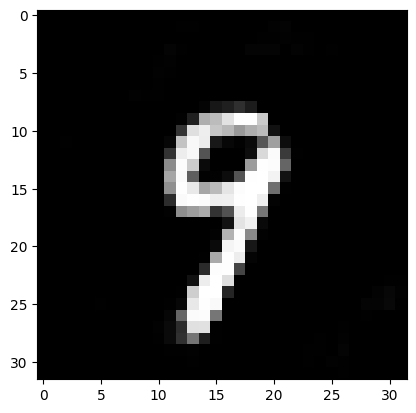

In [33]:
import matplotlib.pyplot as plt

print (z_.shape)
print (y_label_.shape)

G_try = G(z_, y_label_)
print(G_try.shape)
plt.imshow(G_try.detach().cpu().numpy()[1, 0], cmap='gray')
plt.show()

In [34]:
labels = y_label_.squeeze().argmax(dim=1).cpu().numpy()

idxs = []
for i in range(10):
    idxs.append(np.where(labels == i)[0][0])

print(idxs)

[0, 20, 3, 2, 18, 15, 5, 4, 19, 1]


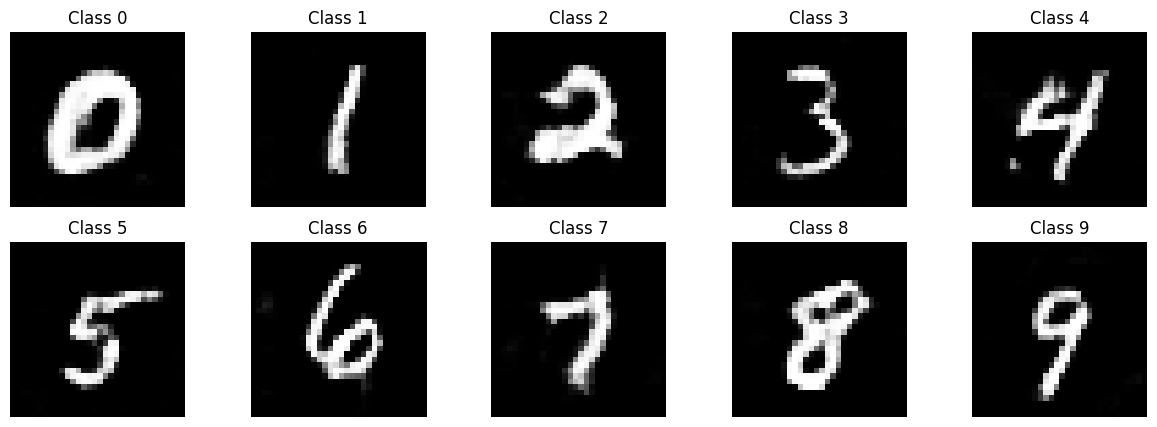

In [35]:
import torch

# Buat noise (z_) untuk 10 sampel (1 untuk tiap kelas)
num_classes = 10
noise_dim = 100
batch_size = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_test = torch.stack([z_[i] for i in idxs]).to(device)
y_label_test = torch.stack([y_label_[i] for i in idxs]).to(device)

# Inferensi dengan Generator
G.eval()  # Set generator ke eval mode
with torch.no_grad():
    generated_images = G(z_test, y_label_test)

# Visualisasi hasil
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i in range(num_classes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i, 0].detach().cpu().numpy(), cmap="gray")
    plt.title(f"Class {i}")
    plt.axis("off")
plt.show()

##### Validation Data

In [46]:
final_pre_val_pairs, _ = make_pairs(best_model, X_val_pre, y_val_pre, img_val_pre)

214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


In [47]:
all_z_val = torch.cat([torch.tensor(z) for z, _, _ in final_pre_val_pairs], dim=0)
all_y_val = torch.cat([torch.tensor(y) for _, y, _ in final_pre_val_pairs], dim=0)

real_imgs_val = torch.cat([torch.tensor(img).unsqueeze(0) for _, _, img in final_pre_val_pairs])
real_imgs_val = (real_imgs_val.float() / 255.0 - 0.5) / 0.5

fixed_z_val = all_z_val.view(-1, 100, 1, 1).float().cuda()
fixed_y_label_val = all_y_val.view(-1, 10, 1, 1).float().cuda()
real_imgs_val = real_imgs_val.unsqueeze(1).cuda()

In [48]:
val_labels = fixed_y_label_val.squeeze().argmax(dim=1).cpu().numpy()

idxs_val = []
for i in range(10):
    idxs_val.append(np.where(val_labels == i)[0][0])

print(idxs_val)

[1, 4, 9, 14, 6, 17, 0, 11, 3, 5]


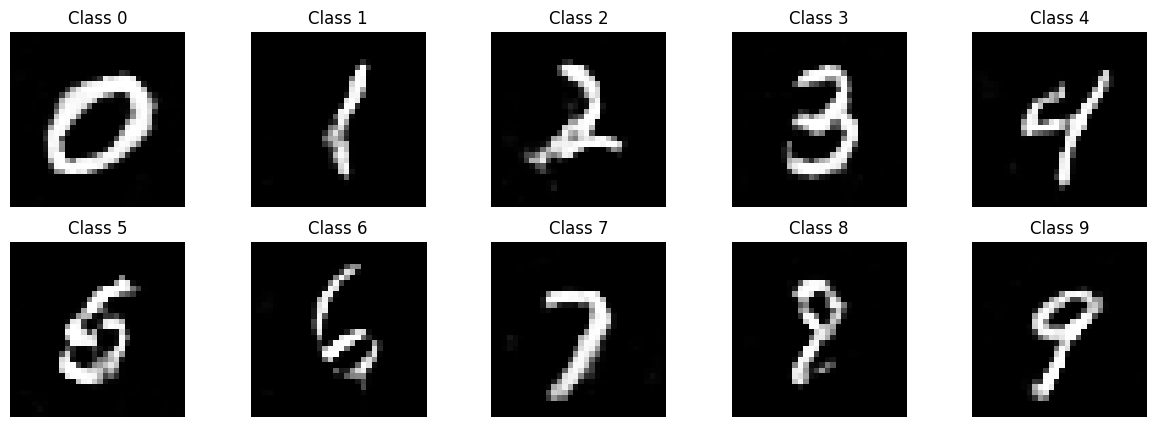

In [39]:
num_classes = 10
noise_dim = 100
batch_size = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_test = torch.stack([fixed_z_val[i] for i in idxs_val]).view(-1, 100, 1, 1).to(device)
y_label_test = torch.stack([fixed_y_label_val[i] for i in idxs_val]).view(-1, 10, 1, 1).to(device)

# Inferensi dengan Generator
G.eval()  # Set generator ke eval mode
with torch.no_grad():
    generated_images = G(z_test, y_label_test)

# Visualisasi hasil
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i in range(num_classes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i, 0].detach().cpu().numpy(), cmap="gray")
    plt.title(f"Class {i}")
    plt.axis("off")
plt.show()

#### LOAD MODEL

In [37]:
import torch
import os

# Path ke model
generator_path = "/kaggle/input/reimage-generation-models/tensorflow2/default/1/MNIST_cDCGAN_generator_param.pkl"
discriminator_path = "/kaggle/input/reimage-generation-models/tensorflow2/default/1/MNIST_cDCGAN_discriminator_param.pkl"

# Load model
G = generator(128)
D = discriminator(128)

# Load parameter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.load_state_dict(torch.load(generator_path, map_location=device))
D.load_state_dict(torch.load(discriminator_path, map_location=device))

G.eval()
D.eval()

print("Models loaded successfully!")

Models loaded successfully!


#### METRICS

In [31]:
# SSIM
from skimage.metrics import structural_similarity as ssim

def SSIM(generated, original):
    score = ssim(generated, original, data_range=original.max() - original.min())
    return score

In [32]:
# PSNR
# Source: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [33]:
from torchmetrics.multimodal.clip_score import CLIPScore
import torch
import numpy as np
from PIL import Image

metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")
number_text = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

def CLIP_score(image, label_onehot):
    try:
        if isinstance(label_onehot, np.ndarray) and len(label_onehot.shape) == 2:
            label = int(np.argmax(label_onehot, axis=1).squeeze().item())
        else:
            label = int(np.argmax(label_onehot))

        if isinstance(image, np.ndarray):
            image_tensor = torch.tensor(image).float()
        else:
            image_tensor = image.float()

        image_tensor = torch.clamp(image_tensor, 0.0, 1.0)

        if image_tensor.ndim == 2:
            image_tensor = image_tensor.unsqueeze(0)
        if image_tensor.shape[0] != 3:
            image_tensor = image_tensor.repeat(3, 1, 1)

        image_tensor = image_tensor.unsqueeze(0).to(metric.device)
        prompt = f"white handwritten digit {number_text[label]} with black background"
        return metric(image_tensor, [prompt]).item()

    except Exception as e:
        print("CLIP_score error:", e)
        return None

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [42]:
!pip install -q torchmetrics
!pip install -q torch-fidelity

# IS & FID
import torch_fidelity
from torchvision.utils import save_image
import os
import tempfile

def compute_fidelity_metrics(fake_images, real_images, device='cuda'):
    import torchvision.transforms.functional as TF

    with tempfile.TemporaryDirectory() as tmpdir:
        fake_dir = os.path.join(tmpdir, 'fake')
        real_dir = os.path.join(tmpdir, 'real')
        os.makedirs(fake_dir, exist_ok=True)
        os.makedirs(real_dir, exist_ok=True)

        for i, img in enumerate(fake_images):
            img = img.detach().cpu().float()
            if img.min() < 0:
                img = (img + 1) / 2
            img = torch.clamp(img, 0, 1)
            if img.shape[0] == 1:
                img = img.repeat(3, 1, 1)
            save_image(img.squeeze(0), os.path.join(fake_dir, f"{i}.png"))

        for i, img in enumerate(real_images):
            img = img.detach().cpu().float()
            if img.min() < 0:
                img = (img + 1) / 2
            img = torch.clamp(img, 0, 1)
            if img.shape[0] == 1:
                img = img.repeat(3, 1, 1)
            save_image(img.squeeze(0), os.path.join(real_dir, f"{i}.png"))

        metrics = torch_fidelity.calculate_metrics (
            input1=fake_dir,
            input2=real_dir,
            cuda=torch.cuda.is_available(),
            isc=True,
            fid=True,
            verbose=False
        )
    return metrics['inception_score_mean'], metrics['inception_score_std'], metrics['frechet_inception_distance']

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 16.5 MB/s eta 0:00:00:00:0100:01


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
def RMSE(fake_image, target_image):
    rmse_score = np.sqrt(np.mean((fake_image - target_image) ** 2)) 
    return rmse_score

#### SUPPORTING FUNCTIONS

In [43]:
def compute_metrics(G, D, G_base, D_base, pairs, device, n_per_class=5):
    G.eval()
    D.eval()
    G_base.eval()
    D_base.eval()

    G_base = G_base.to(device)
    D_base = D_base.to(device)

    results = {}
    all_generated = []
    all_real = []

    for label in range(10):
        class_pairs = [p for p in pairs if np.argmax(p[1]) == label][:n_per_class]
        ssim_scores, psnr_scores, clip_scores, rmse_scores = [], [], [], []

        fig, axes = plt.subplots(3, n_per_class, figsize=(n_per_class * 2.2, 6))
        fig.suptitle(f"Class {label}", fontsize=12)

        for i, (latent_input, label_onehot, target_image) in enumerate(class_pairs):
            latent_input = torch.tensor(latent_input, dtype=torch.float32).to(device)
            latent_input = latent_input.unsqueeze(0).unsqueeze(2).unsqueeze(3)
            
            label_tensor = torch.tensor(label_onehot, dtype=torch.float32).to(device).view(1, 10, 1, 1)
            label_img = label_tensor.repeat(1, 1, 32, 32)

            with torch.no_grad():
                # --- Baseline model ---
                fake_base = G_base(latent_input, label_tensor)
                d_base_score = D_base(fake_base, label_img).squeeze().item()

                fake_base = torch.clamp((fake_base + 1) / 2, 0, 1)
                fake_base_np = fake_base.squeeze().cpu().numpy()

                # --- Fine-tuned model ---
                fake_image = G(latent_input, label_tensor)
                d_score = D(fake_image, label_img).squeeze().item()

                fake_image = torch.clamp((fake_image + 1) / 2, 0, 1)
                fake_np = fake_image.squeeze().cpu().numpy()

            target_image_np = np.array(target_image.astype(np.float32) / 255.0)

            # Metrics for fine-tuned model
            rmse = RMSE(fake_np, target_image_np)
            ssim = SSIM(fake_np, target_image_np)
            psnr = PSNR(target_image_np, fake_np)
            clip = CLIP_score(fake_np, label_onehot)

            # (Optional) Metrics for base model
            rmse_base = RMSE(fake_base_np, target_image_np)
            ssim_base = SSIM(fake_base_np, target_image_np)
            psnr_base = PSNR(target_image_np, fake_base_np)
            clip_base = CLIP_score(fake_base_np, label_onehot)

            # Store fine-tuned metrics only for final averaging
            ssim_scores.append(ssim)
            psnr_scores.append(psnr)
            clip_scores.append(clip)
            rmse_scores.append(rmse)

            all_generated.append(fake_image)
            all_real.append(torch.tensor(target_image_np).unsqueeze(0).unsqueeze(0))

            # --- Visualization ---
            # Row 0: Baseline
            axes[0, i].imshow(fake_base_np, cmap='gray')
            axes[0, i].set_title(
                f"Base\nD:{d_base_score:.2f}\nSSIM:{ssim_base:.2f} PSNR:{psnr_base:.2f}\nCLIP:{clip_base:.2f} RMSE:{rmse_base:.3f}",
                fontsize=7
            )
            axes[0, i].axis("off")

            # Row 1: Finetuned
            axes[1, i].imshow(fake_np, cmap='gray')
            axes[1, i].set_title(
                f"Finetuned\nD:{d_score:.2f}\nSSIM:{ssim:.2f} PSNR:{psnr:.2f}\nCLIP:{clip:.2f} RMSE:{rmse:.3f}",
                fontsize=7
            )
            axes[1, i].axis("off")

            # Row 2: Ground Truth
            axes[2, i].imshow(target_image, cmap='gray')
            axes[2, i].set_title("Ground Truth", fontsize=7)
            axes[2, i].axis("off")

        plt.subplots_adjust(wspace=0.3, hspace=0.1)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        results[label] = {
            "SSIM": np.mean(ssim_scores),
            "PSNR": np.mean(psnr_scores),
            "CLIP": np.mean(clip_scores),
            "RMSE": np.mean(rmse_scores)
        }
    return results, torch.cat(all_generated, dim=0), torch.cat(all_real, dim=0)


def evaluate_all(G, D, G_base, D_base, val_pairs, device):
    print("Evaluating per-class generation with metrics and visualization...")
    metric_result, fake_images, real_images = compute_metrics(G, D, G_base, D_base, val_pairs, device)

    print("\nPer-Class Averages:")
    for cls in range(10):
        print(f"Class {cls} - SSIM: {metric_result[cls]['SSIM']:.4f}, "
              f"PSNR: {metric_result[cls]['PSNR']:.2f}, "
              f"CLIP: {metric_result[cls]['CLIP']:.4f}, "
              f"RMSE: {metric_result[cls]['RMSE']:.4f}")

    print("\nCalculating Inception Score and FID...")
    is_mean, is_std, fid_score = compute_fidelity_metrics(fake_images, real_images, device)
    print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")
    print(f"FID Score: {fid_score:.2f}")

#### EVALUATION

In [35]:
# Load Base Models for Comparison
import torch
import os

# Path ke model
generator_path = "/kaggle/input/image-generation-mse/tensorflow2/default/1/MNIST_cDCGAN_generator_param.pkl"
discriminator_path = "/kaggle/input/image-generation-mse/tensorflow2/default/1/MNIST_cDCGAN_discriminator_param.pkl"

# Load model
G_base = generator(128)
D_base = discriminator(128)

# Load parameter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_base.load_state_dict(torch.load(generator_path, map_location=device))
D_base.load_state_dict(torch.load(discriminator_path, map_location=device))

G_base.eval()
D_base.eval()

print("Models loaded successfully!")

Models loaded successfully!


Evaluating per-class generation with metrics and visualization...


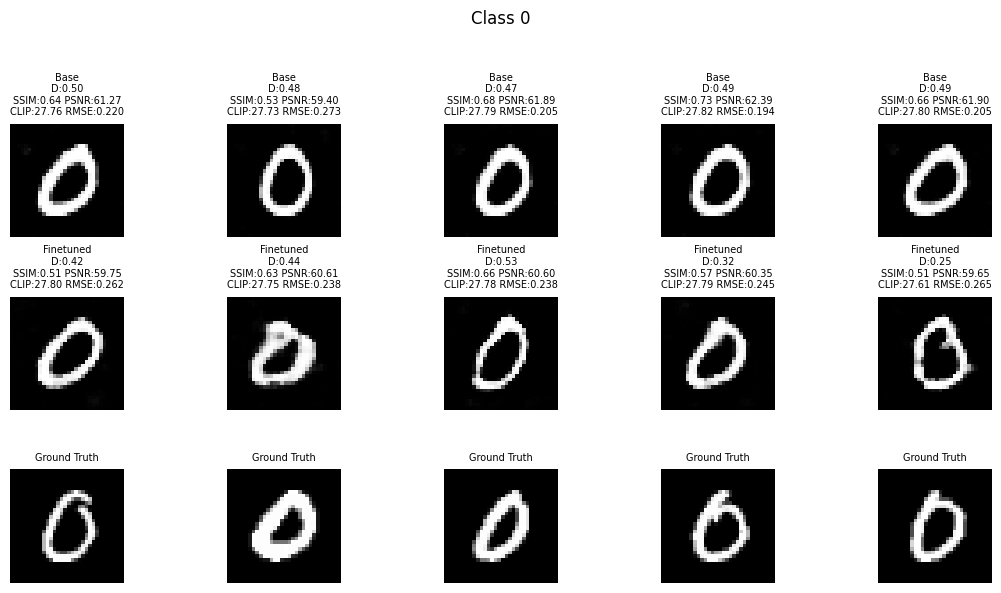

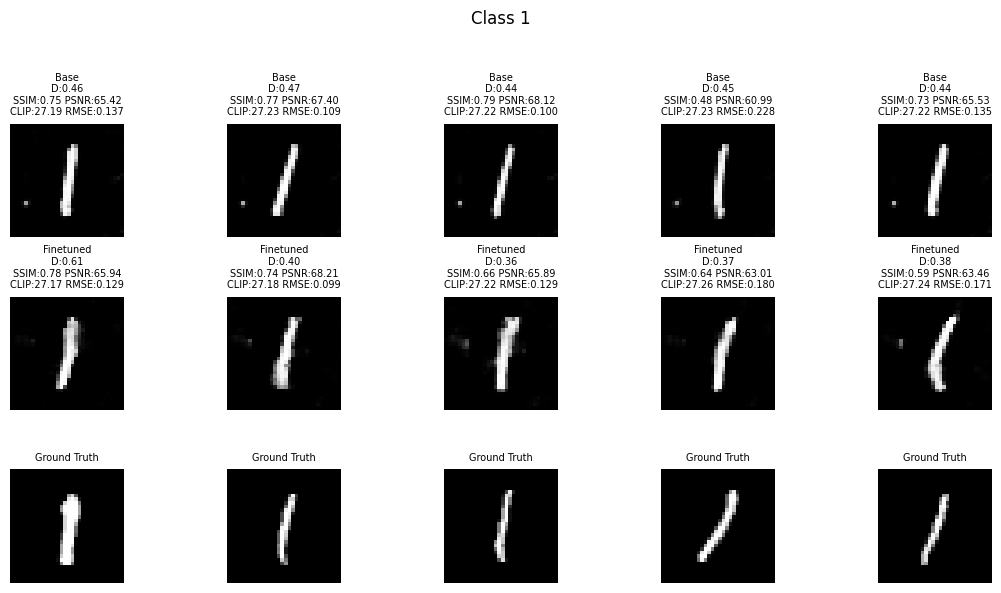

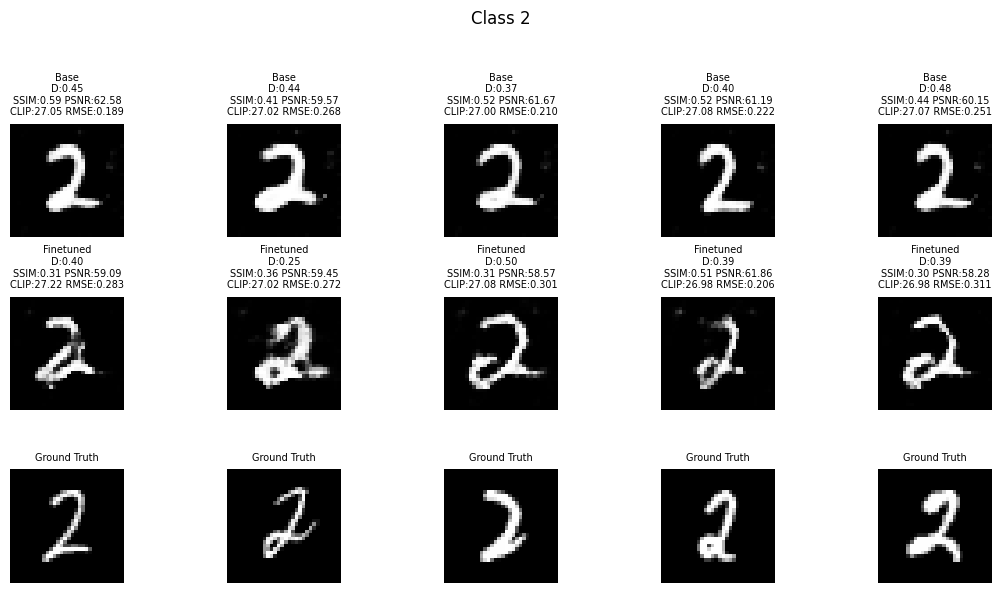

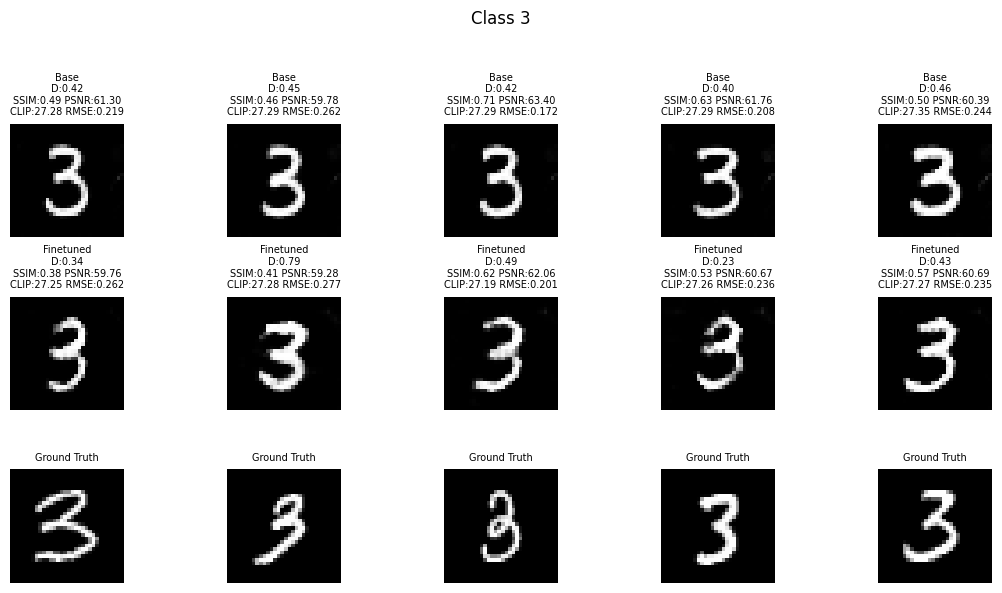

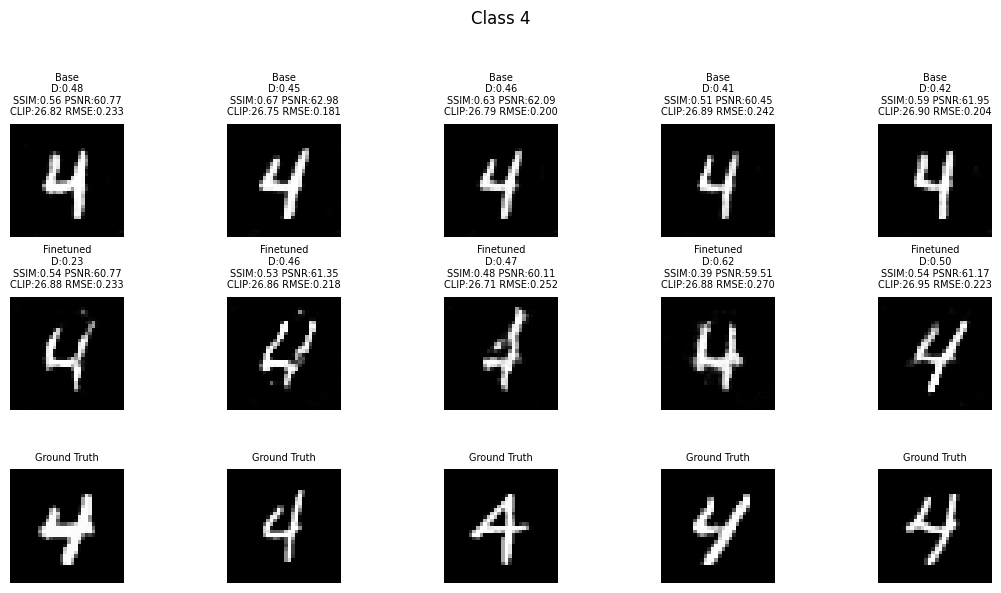

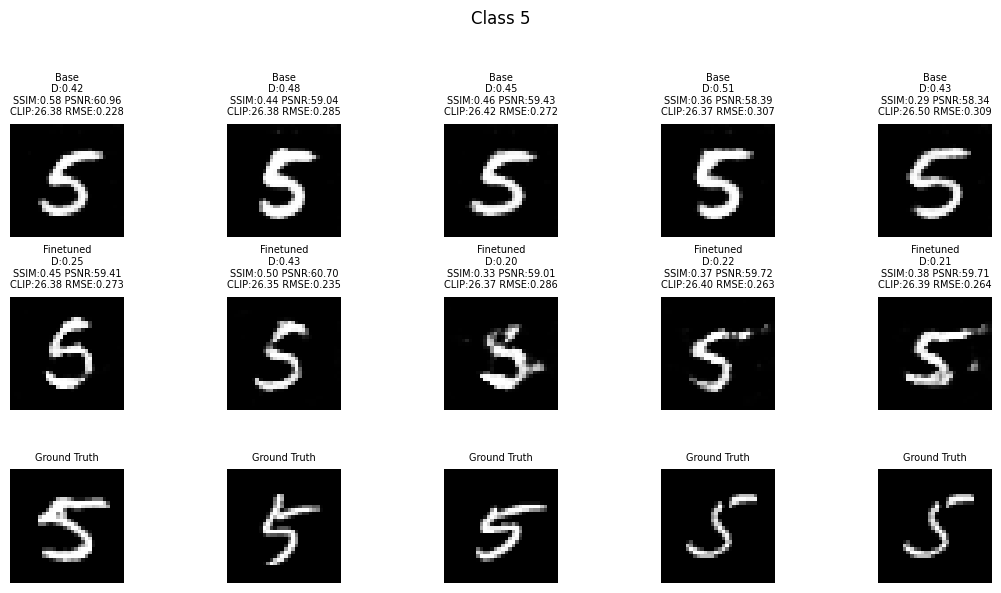

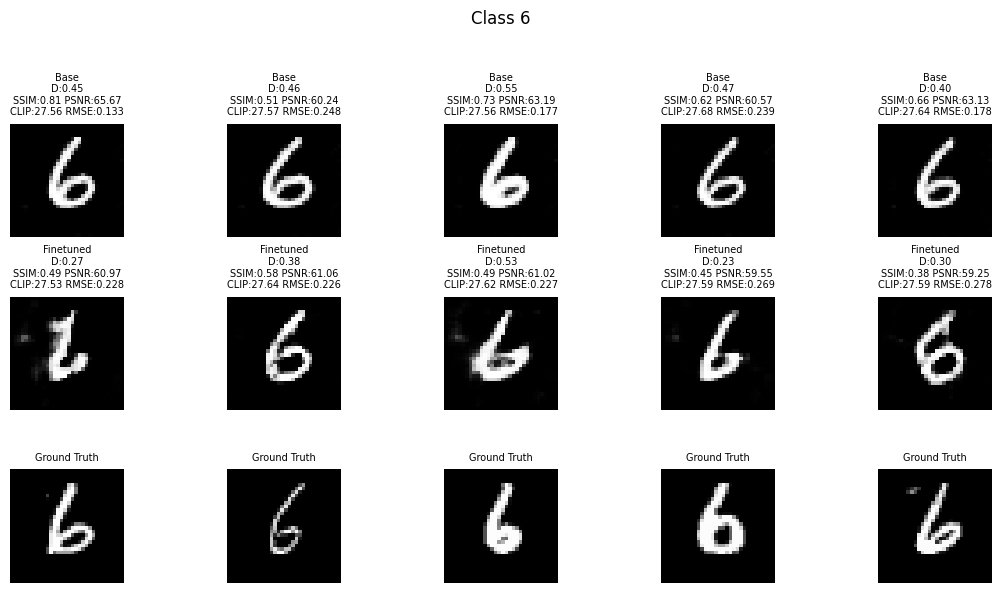

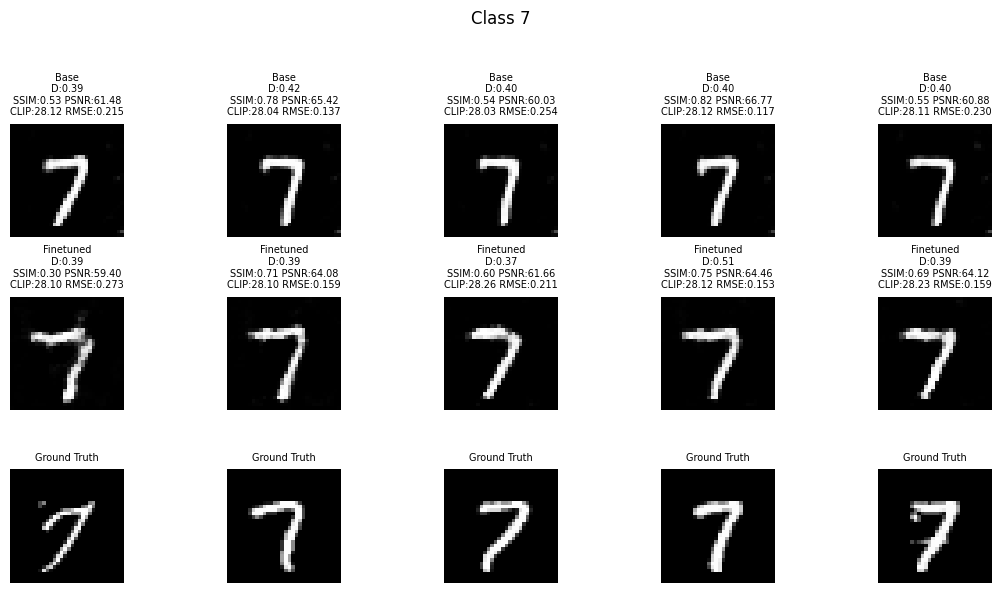

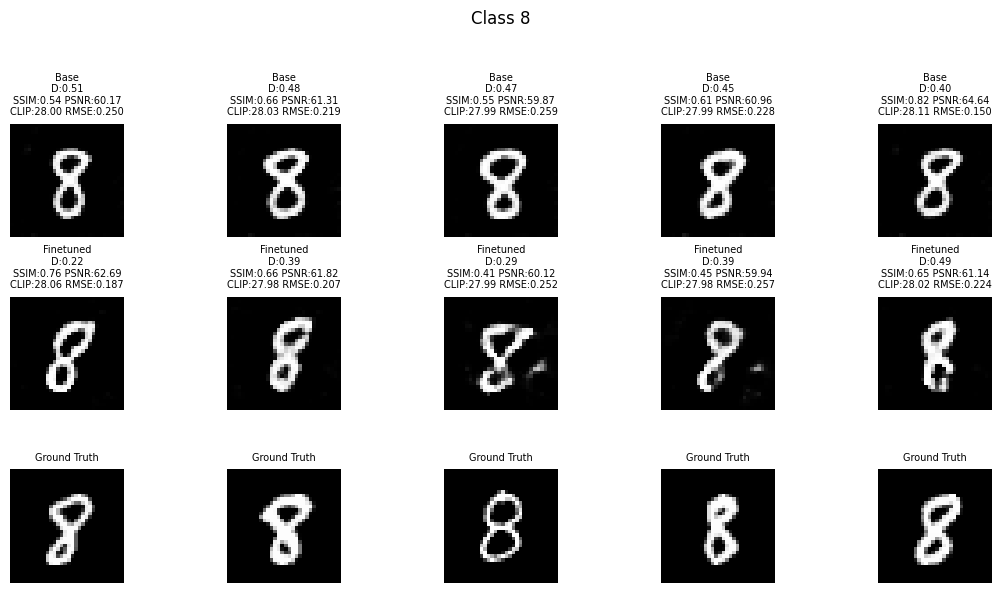

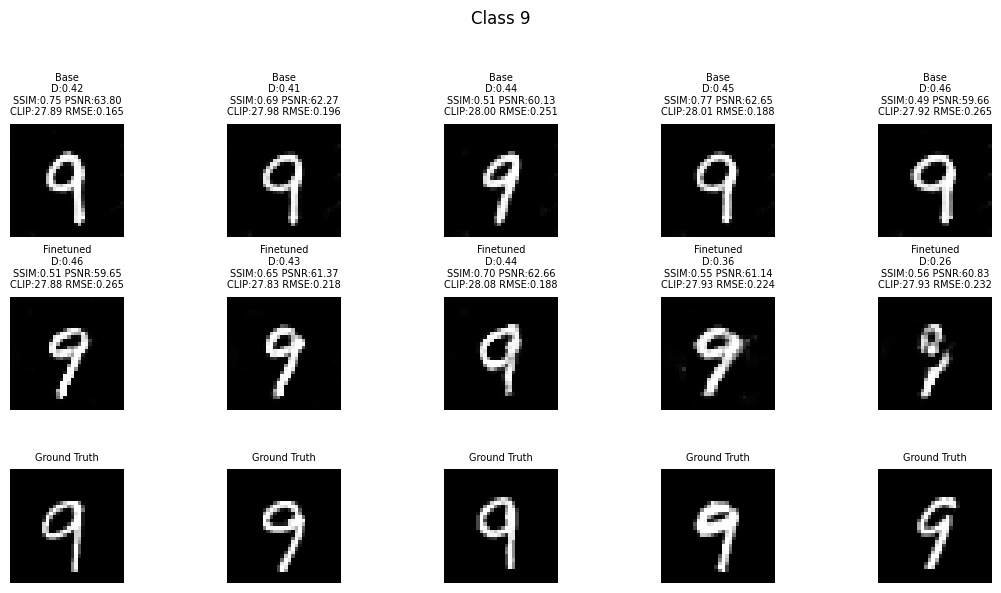


Per-Class Averages:
Class 0 - SSIM: 0.5751, PSNR: 60.19, CLIP: 27.7483, RMSE: 0.2496
Class 1 - SSIM: 0.6808, PSNR: 65.30, CLIP: 27.2147, RMSE: 0.1417
Class 2 - SSIM: 0.3601, PSNR: 59.45, CLIP: 27.0565, RMSE: 0.2744
Class 3 - SSIM: 0.5045, PSNR: 60.49, CLIP: 27.2506, RMSE: 0.2424
Class 4 - SSIM: 0.4951, PSNR: 60.58, CLIP: 26.8555, RMSE: 0.2392
Class 5 - SSIM: 0.4066, PSNR: 59.71, CLIP: 26.3774, RMSE: 0.2642
Class 6 - SSIM: 0.4775, PSNR: 60.37, CLIP: 27.5947, RMSE: 0.2454
Class 7 - SSIM: 0.6094, PSNR: 62.74, CLIP: 28.1620, RMSE: 0.1909
Class 8 - SSIM: 0.5852, PSNR: 61.14, CLIP: 28.0031, RMSE: 0.2252
Class 9 - SSIM: 0.5941, PSNR: 61.13, CLIP: 27.9320, RMSE: 0.2253

Calculating Inception Score and FID...


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 182MB/s]
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZER

Inception Score: 1.63 ± 0.25
FID Score: 96.04


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.eval().to(device)
D.eval().to(device)
evaluate_all(G, D, G_base, D_base, final_pre_pairs, device)

Evaluating per-class generation with metrics and visualization...


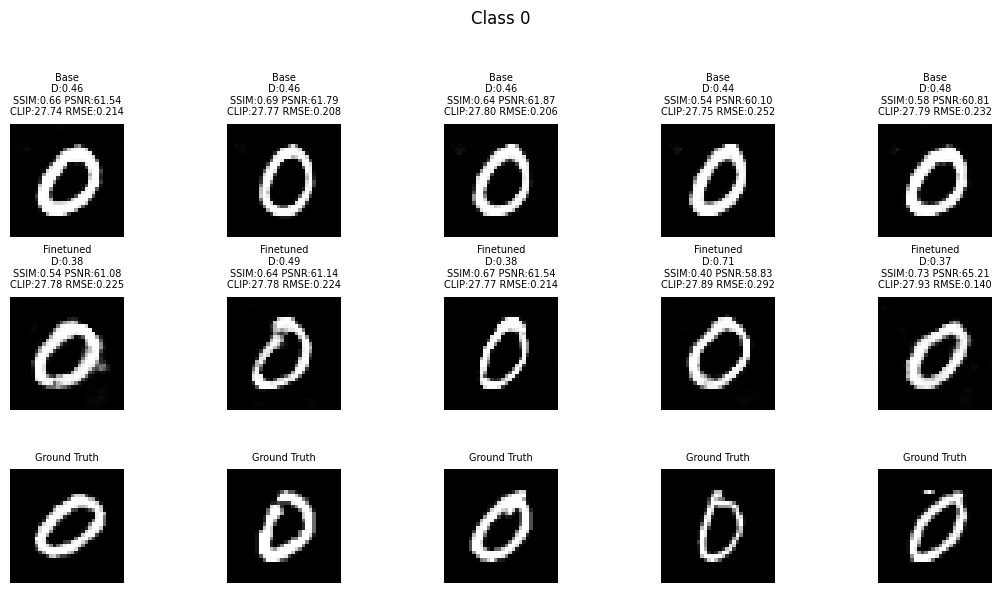

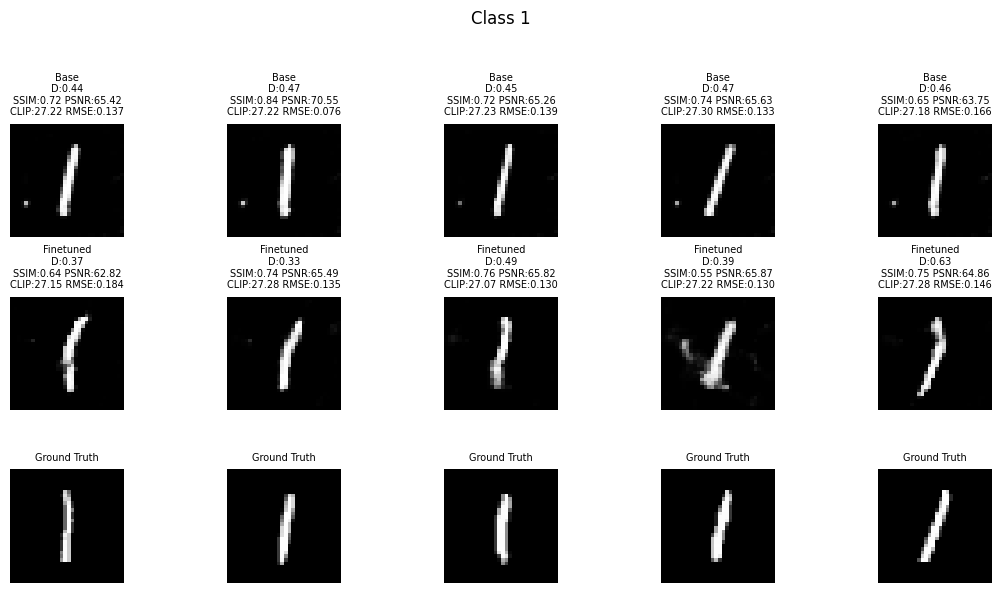

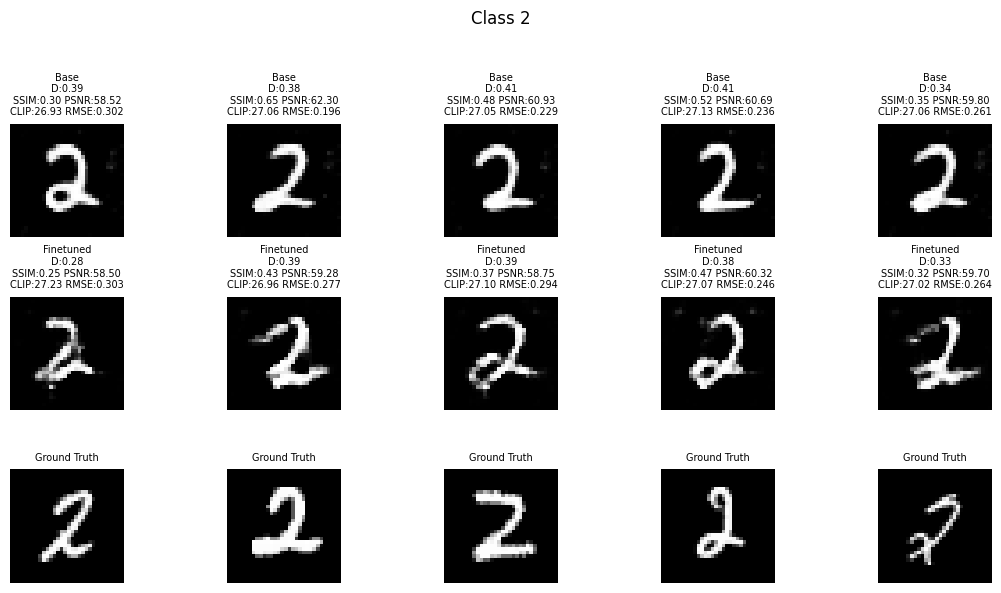

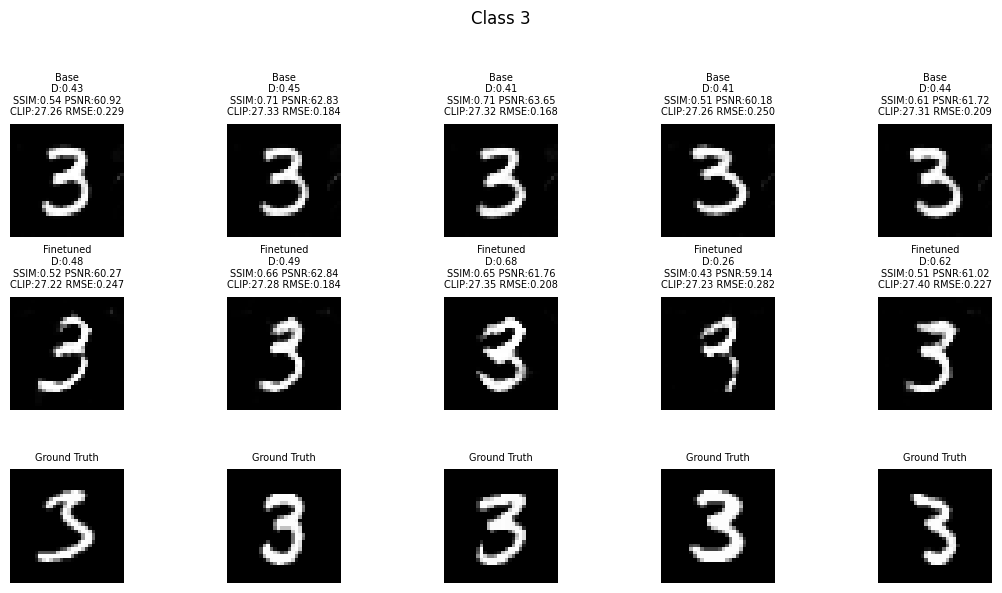

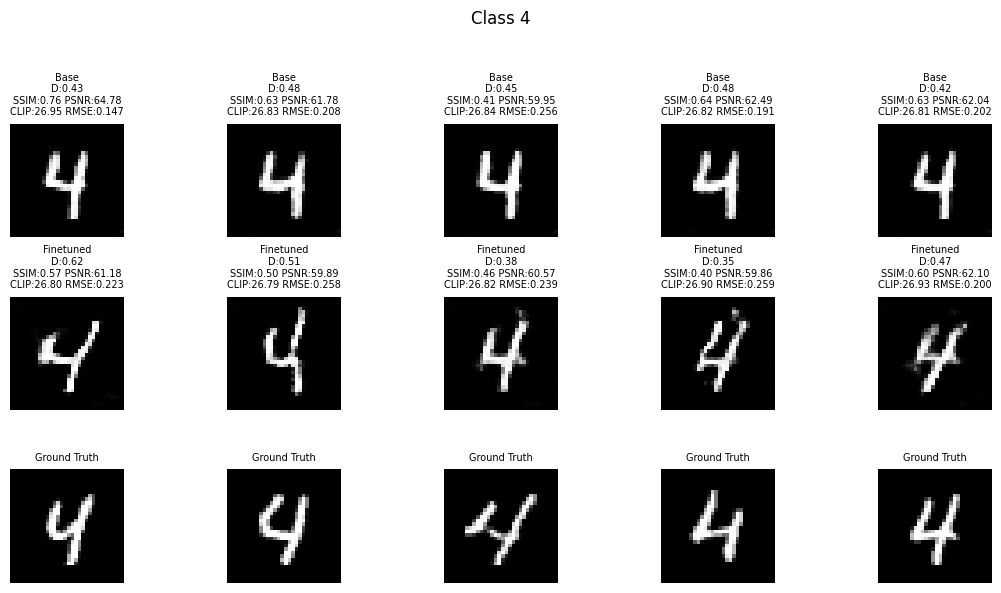

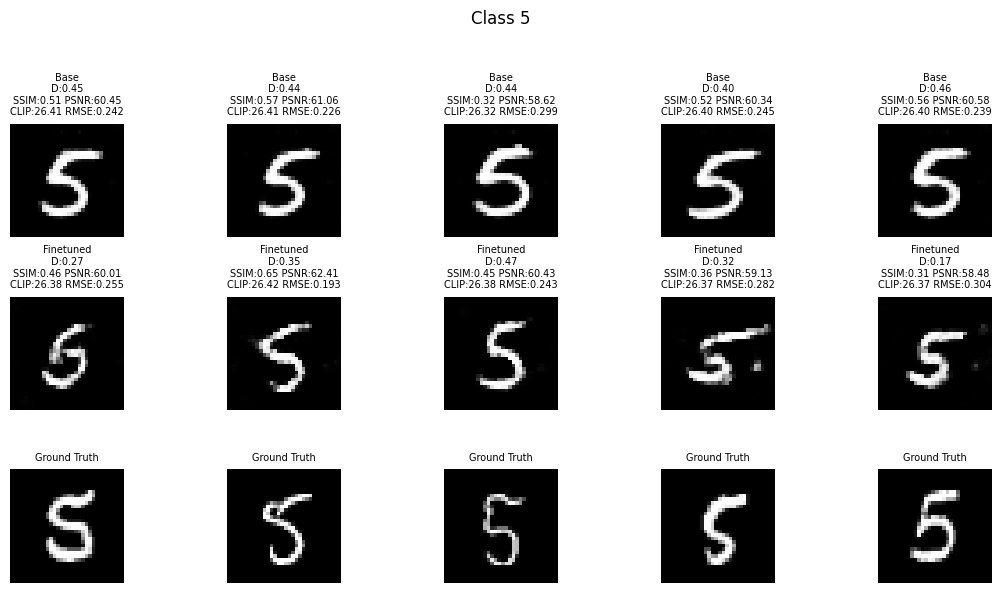

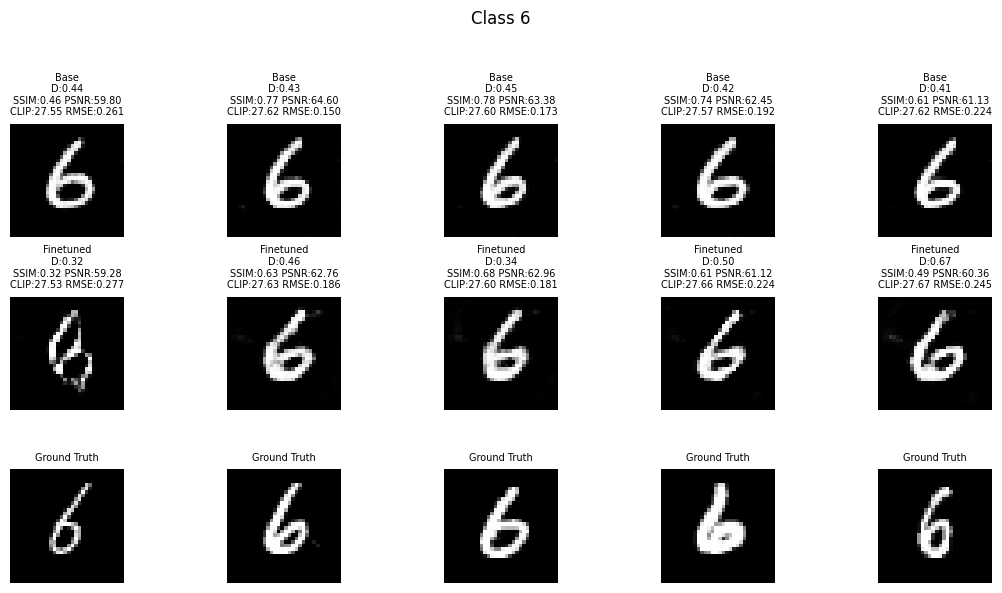

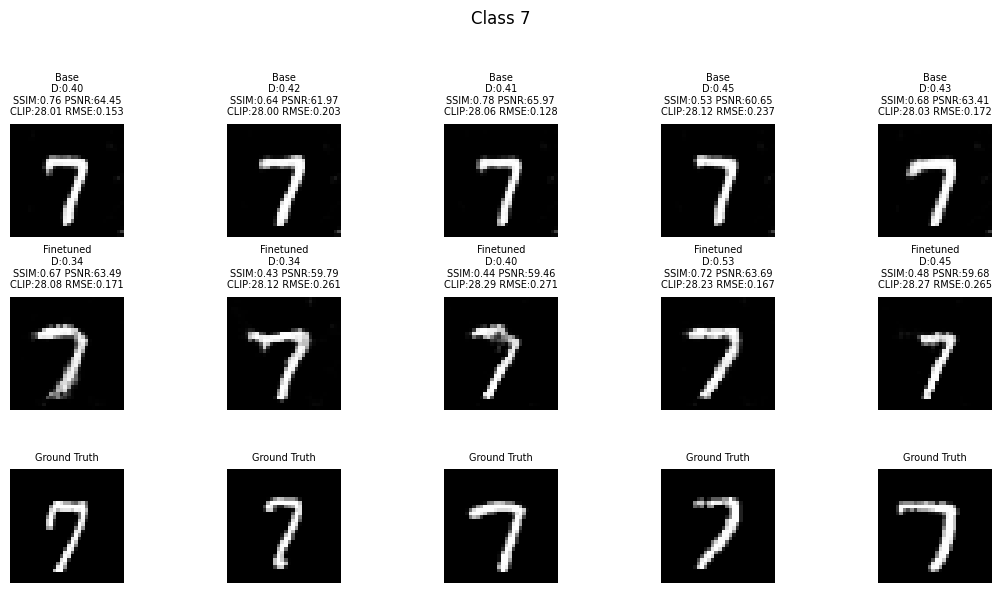

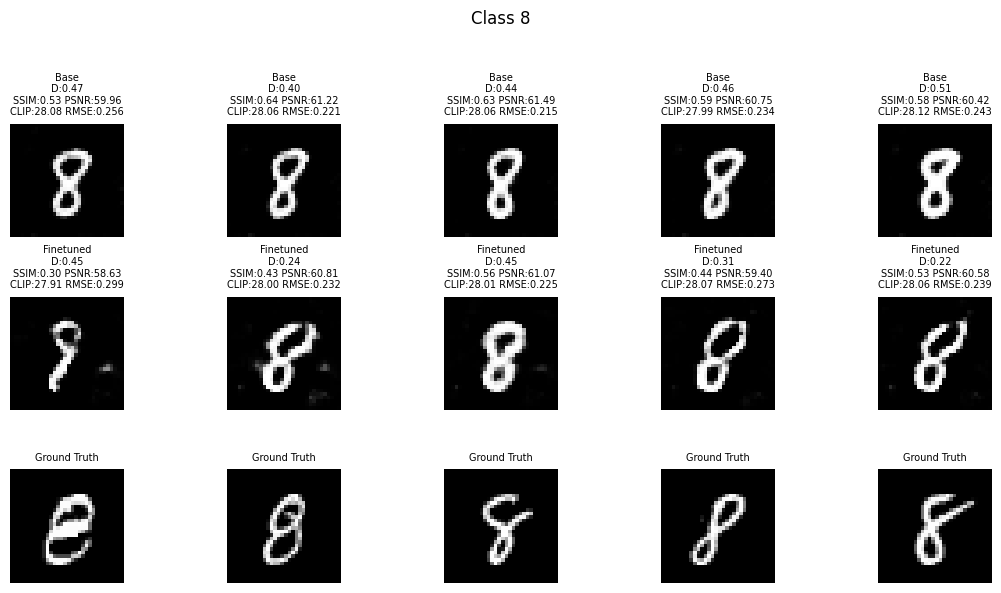

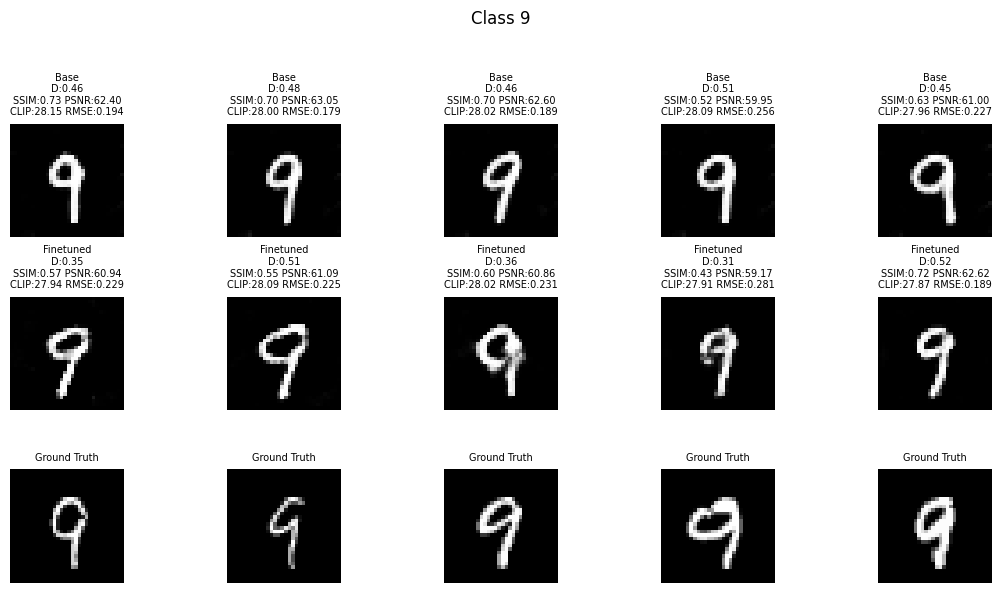


Per-Class Averages:
Class 0 - SSIM: 0.5959, PSNR: 61.56, CLIP: 27.8312, RMSE: 0.2188
Class 1 - SSIM: 0.6856, PSNR: 64.97, CLIP: 27.1994, RMSE: 0.1452
Class 2 - SSIM: 0.3671, PSNR: 59.31, CLIP: 27.0766, RMSE: 0.2768
Class 3 - SSIM: 0.5549, PSNR: 61.00, CLIP: 27.2974, RMSE: 0.2296
Class 4 - SSIM: 0.5060, PSNR: 60.72, CLIP: 26.8487, RMSE: 0.2358
Class 5 - SSIM: 0.4446, PSNR: 60.09, CLIP: 26.3856, RMSE: 0.2553
Class 6 - SSIM: 0.5478, PSNR: 61.30, CLIP: 27.6155, RMSE: 0.2226
Class 7 - SSIM: 0.5478, PSNR: 61.22, CLIP: 28.1969, RMSE: 0.2269
Class 8 - SSIM: 0.4526, PSNR: 60.10, CLIP: 28.0091, RMSE: 0.2536
Class 9 - SSIM: 0.5760, PSNR: 60.94, CLIP: 27.9663, RMSE: 0.2308

Calculating Inception Score and FID...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Inception Score: 1.69 ± 0.30
FID Score: 91.17


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.eval().to(device)
D.eval().to(device)
evaluate_all(G, D, G_base, D_base, final_pre_val_pairs, device)